<a href="https://colab.research.google.com/github/fabiormazza/IA025_2022S1/blob/main/projeto_final/fabio_mazza/projeto_final_modulos12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install wandb
!wandb login

In [1]:
!pip install datasets
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 362 kB 14.7 MB/s 
     |████████████████████████████████| 1.1 MB 57.3 MB/s 
     |████████████████████████████████| 101 kB 12.7 MB/s 
     |████████████████████████████████| 212 kB 61.4 MB/s 
     |████████████████████████████████| 140 kB 57.4 MB/s 
     |████████████████████████████████| 596 kB 61.5 MB/s 
     |████████████████████████████████| 127 kB 65.1 MB/s 
     |████████████████████████████████| 94 kB 4.2 MB/s 
     |████████████████████████████████| 144 kB 63.1 MB/s 
     |████████████████████████████████| 271 kB 52.1 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
ERROR: pip's de

# Download Datasets - Módulos 1 e 2

In [ ]:
import wandb
wandb.init(project="image-to-label", entity="fabiormazza")

In [ ]:
## Get dataset images

!wget -c http://images.cocodataset.org/zips/train2017.zip
!wget -c http://images.cocodataset.org/zips/val2017.zip

!unzip "/content/train2017.zip"
!unzip "/content/val2017.zip"

In [ ]:
## Get dataset annotations

!wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip
!unzip "/content/annotations_trainval2017.zip"

!wget http://images.cocodataset.org/annotations/stuff_annotations_trainval2017.zip
!unzip "/content/stuff_annotations_trainval2017.zip"


In [2]:
%matplotlib inline
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab
pylab.rcParams['figure.figsize'] = (8.0, 10.0)

In [3]:
import collections
import itertools
import functools
import math
import random

import torch
import torch.nn as nn
from torch import Tensor
import numpy as np
from torch.utils.data import DataLoader
import tqdm

from collections import OrderedDict
from typing import List
import torchvision.transforms as transforms
import torchvision.models as models

from typing import Tuple
import torch.nn.functional as F
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from torch.nn import TransformerDecoder, TransformerDecoderLayer

import transformers

In [ ]:
dataDir='/content'

## Annotations from instances of objects train/val

aFile_inst_train='{}/annotations/instances_train2017.json'.format(dataDir) ## Annotation file - train
aFile_inst_val='{}/annotations/instances_val2017.json'.format(dataDir) ## Annotation file - validation

## Annotations from "stuff" train/val

aFile_stuff_train='{}/annotations/stuff_train2017.json'.format(dataDir) ## Annotation file - train
aFile_stuff_val='{}/annotations/stuff_val2017.json'.format(dataDir) ## Annotation file - validation

coco_inst_train = COCO(aFile_inst_train)
coco_inst_val = COCO(aFile_inst_val)

coco_stuff_train = COCO(aFile_stuff_train)
coco_stuff_val = COCO(aFile_stuff_val)

In [4]:
# Check which GPU we are using
!nvidia-smi

Sat Jul  2 16:00:04 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    23W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
if torch.cuda.is_available(): 
   dev = "cuda:0"
else: 
   dev = "cpu"
device = torch.device(dev)
print('Using {}'.format(device))

Using cuda:0


# Módulo 1 - Implementação do MyDataset

In [ ]:
## Image transformations

transformations = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.Lambda(lambda x: x.expand(3,-1,-1)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [ ]:
class MyDataset(torch.utils.data.Dataset):

  def __init__(self, img_ids: List[int], coco_inst, coco_stuff, file_dir: str, transformations, num_cats: int):
    self.img_ids = img_ids
    self.coco_inst = coco_inst
    self.coco_stuff = coco_stuff
    self.transformations = transformations
    self.num_cats = num_cats

    ## Inputs
    #imgs_info = self.coco.loadImgs(self.img_ids)
    #imgs_url = [imgs_info[i]['coco_url'] for i in tqdm.notebook.tqdm(range(len(imgs_info)))]
    img_ids_str = list(map(str, img_ids))
    imgs = [self.transformations(io.imread(f'/content/{file_dir}/{img_ids_str[i].zfill(12)}.jpg')) for i in tqdm.notebook.tqdm(range(len(img_ids_str)))]
    
    self.inputs = imgs

    ## Targets
    targets = torch.tensor([])

    for id in tqdm.notebook.tqdm(img_ids):
      ann_id_inst = self.coco_inst.getAnnIds(id)
      ann_id_stuff = self.coco_stuff.getAnnIds(id)

      anns_inst = self.coco_inst.loadAnns(ann_id_inst)
      anns_stuff = self.coco_stuff.loadAnns(ann_id_stuff)
      anns = anns_inst + anns_stuff      

      cat_idxs = [anns[j]['category_id'] for j in range(len(anns))]
      tgt = torch.zeros(self.num_cats)
      tgt[cat_idxs] = 1
      tgt = tgt.unsqueeze(0)
      targets = torch.cat((targets, tgt), dim=0)
    
    self.targets = targets


  def __len__(self):
    return len(self.img_ids)
  
  def __getitem__(self, idx):
    return self.inputs[idx], self.targets[idx]

In [ ]:
all_cat_ids = coco_inst_train.getCatIds() + coco_stuff_train.getCatIds()
num_cats = all_cat_ids[-1] + 1 #zero is included to facilitate index identification, even if there is no cat with id = '0'

# Módulo 1 - Assert do MyDataset

In [ ]:
## Dataset

dummy_image_ids = [391895, 522418, 184613, 318219, 554625]
dummy_dataset = MyDataset(img_ids=dummy_image_ids, coco_inst=coco_inst_train, coco_stuff=coco_stuff_train, file_dir='train2017', transformations=transformations, num_cats=num_cats)
dummy_loader = DataLoader(dummy_dataset, batch_size=5, shuffle=False)
assert len(dummy_dataset) == 5
print('Passou no assert de tamanho do dataset.')

first_batch_input, first_batch_target = next(iter(dummy_loader))

imgs_url = ['http://images.cocodataset.org/train2017/000000391895.jpg',
 'http://images.cocodataset.org/train2017/000000522418.jpg',
 'http://images.cocodataset.org/train2017/000000184613.jpg',
 'http://images.cocodataset.org/train2017/000000318219.jpg',
 'http://images.cocodataset.org/train2017/000000554625.jpg']

correct_first_batch_input = torch.tensor([])

for i in range(len(imgs_url)):
  correct_first_batch_input = torch.cat((correct_first_batch_input, transformations(io.imread(imgs_url[i]))), dim=0)

correct_first_batch_input = correct_first_batch_input.view(5, 3, 224, 224)
correct_first_batch_input = torch.FloatTensor(correct_first_batch_input)

assert torch.equal(first_batch_input, correct_first_batch_input)
print('Passou no assert do input do dataset')

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Passou no assert de tamanho do dataset.
Passou no assert do input do dataset


In [ ]:
## Verificação de um item do batch do dataset (input e target)
dummy_dataset[4]

(tensor([[[ 2.1847,  2.1975,  2.2000,  ...,  1.5958,  1.7502,  1.7454],
          [ 2.1893,  2.2098,  2.2147,  ...,  1.2540,  1.6762,  1.7460],
          [ 2.2316,  2.2147,  2.1847,  ...,  1.0032,  1.5065,  1.6916],
          ...,
          [-1.7464, -1.7624, -1.7424,  ..., -0.6268, -0.9589, -1.1221],
          [-1.7592, -1.7769, -1.7632,  ..., -0.8117, -1.2109, -0.7916],
          [-1.7598, -1.7604, -1.7589,  ..., -1.1408, -0.9556, -0.5506]],
 
         [[ 2.3804,  2.3936,  2.3886,  ...,  0.7892,  0.8336,  0.7926],
          [ 2.3768,  2.3810,  2.3761,  ...,  0.5911,  0.8378,  0.8267],
          [ 2.3934,  2.3761,  2.3717,  ...,  0.4422,  0.7533,  0.8653],
          ...,
          [-1.6559, -1.6723, -1.6518,  ..., -0.7802, -1.1426, -1.3269],
          [-1.6690, -1.6871, -1.6731,  ..., -1.0211, -1.3536, -0.9635],
          [-1.6696, -1.6702, -1.6687,  ..., -1.3225, -1.1605, -0.7436]],
 
         [[ 2.4875,  2.5006,  2.4993,  ...,  0.5205,  0.4436,  0.4035],
          [ 2.4881,  2.5006,

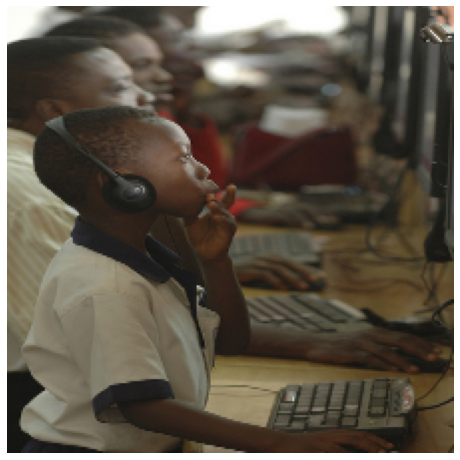

[{'supercategory': 'person', 'id': 1, 'name': 'person'}, {'supercategory': 'electronic', 'id': 72, 'name': 'tv'}, {'supercategory': 'electronic', 'id': 74, 'name': 'mouse'}, {'supercategory': 'electronic', 'id': 76, 'name': 'keyboard'}] 
 [{'supercategory': 'textile', 'id': 105, 'name': 'clothes'}, {'supercategory': 'furniture-stuff', 'id': 110, 'name': 'desk-stuff'}, {'supercategory': 'wall', 'id': 173, 'name': 'wall-other'}, {'supercategory': 'other', 'id': 183, 'name': 'other'}]


In [ ]:
## Verificação visual do dataset (imagem e categorias = targets)
inv_trans = transforms.Compose([transforms.Normalize(mean = [ 0., 0., 0. ], std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                                transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ], std = [ 1., 1., 1. ]),
                               ])
img, cats = dummy_dataset[4]
cats = torch.nonzero(cats).squeeze().numpy()
plt.axis('off')
plt.imshow(inv_trans(img).permute(1, 2, 0))
plt.show()

cats_inst = cats[cats <= 91]
cats_stuff = cats[cats > 91]

print(coco_inst_train.loadCats(cats_inst), '\n', coco_stuff_train.loadCats(cats_stuff))

# Módulo 1 - Carregamento do Dataset

In [ ]:
##Número de exemplos do dataset
all_img_ids_train = coco_inst_train.getImgIds()
all_img_ids_val_test = coco_inst_val.getImgIds()

data_train_ex_num = len(all_img_ids_train)
data_valid_ex_num = int(len(all_img_ids_val_test) / 2) #validation coco dataset was divided in two sets, one being used as val and other as test (test set is not used in validation or training)
data_test_ex_num = int(len(all_img_ids_val_test) / 2)
all_ex_num = data_train_ex_num + data_valid_ex_num + data_test_ex_num

## Número de exemplos (truncado ou não)
train_ex_num = 50_000 #50_000
valid_ex_num = 2_500 #2_500
test_ex_num = 2_500 #2_500

max_lines = train_ex_num + valid_ex_num + test_ex_num

print(f"Number of examples used: {max_lines}; Number of examples in the dataset: {all_ex_num}")

## Carregamento do Dataset

img_ids_train = all_img_ids_train[:train_ex_num]
img_ids_val = all_img_ids_val_test[:valid_ex_num]
img_ids_test = all_img_ids_val_test[valid_ex_num:valid_ex_num + test_ex_num]

print(f"Train: {len(img_ids_train)}, Valid: {len(img_ids_val)}, Test: {len(img_ids_test)}")

valid_dataset = MyDataset(img_ids=img_ids_val, coco_inst=coco_inst_val, coco_stuff=coco_stuff_val, file_dir='val2017', transformations=transformations, num_cats=num_cats)
test_dataset = MyDataset(img_ids=img_ids_test, coco_inst=coco_inst_val, coco_stuff=coco_stuff_val, file_dir='val2017', transformations=transformations, num_cats=num_cats)
train_dataset = MyDataset(img_ids=img_ids_train, coco_inst=coco_inst_train, coco_stuff=coco_stuff_train, file_dir='train2017', transformations=transformations, num_cats=num_cats)

Number of examples used: 55000; Number of examples in the dataset: 123287
Train: 50000, Valid: 2500, Test: 2500


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/50000 [00:00<?, ?it/s]

  0%|          | 0/50000 [00:00<?, ?it/s]

# Módulo 2 - NLP Dataset

In [6]:
from datasets import load_dataset
datasets2 = load_dataset('wikitext', 'wikitext-103-v1')

Generating test split:   0%|          | 0/4358 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/1801350 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3760 [00:00<?, ? examples/s]

Dataset wikitext downloaded and prepared to /root/.cache/huggingface/datasets/wikitext/wikitext-103-v1/1.0.0/a241db52902eaf2c6aa732210bead40c090019a499ceb13bcbfa3f8ab646a126. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [7]:
texts_train2 = [text for text in datasets2['train']['text'][:] if len(text) > 200]
texts_valid2 = [text for text in datasets2['validation']['text'][:] if len(text) > 200]
texts_test2 = [text for text in datasets2['test']['text'][:] if len(text) > 200]

In [8]:
texts_train2[500]

' In 2002 , Fey was ranked in the Hot 100 List at number 80 on Maxim magazine , which used photos taken earlier by Rolling Stone calling her " the thinking man \'s sex symbol " . She was named one of People magazine \'s 50 Most Beautiful People in 2003 , and one of People magazine \'s 100 Most Beautiful People in 2007 , 2008 , and 2009 . In 2007 , Fey placed seventh on the Hot 100 List on <unk> She repeated the appearance the following year , being voted as number one on the list . \n'

In [9]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
def tokenize(text: str, tokenizer=tokenizer):
    return tokenizer(text, return_tensors=None, add_special_tokens=False).input_ids

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [10]:
tokenize(texts_train2[500])[0:10]

[1130, 1617, 117, 11907, 1183, 1108, 3616, 1107, 1103, 4126]

In [11]:
print(tokenizer.convert_ids_to_tokens(tokenize(texts_train2[500])[0:10]))
print(tokenizer.convert_ids_to_tokens(tokenize(texts_train2[500])[-10:]))

['In', '2002', ',', 'Fe', '##y', 'was', 'ranked', 'in', 'the', 'Hot']
[',', 'being', 'voted', 'as', 'number', 'one', 'on', 'the', 'list', '.']


In [12]:
class MyDataset():
    def __init__(self, texts: List[str], tokenizer, max_seq_length: int):
        
        self.max_seq_length = max_seq_length
        #cls = 101
        #sep = 100
        tokens_all = torch.tensor([])
        inputs = torch.tensor([])
        targets = torch.tensor([])
 
        for text in tqdm.notebook.tqdm(texts):
            tokens = tokenize(text, tokenizer)
            #tokens = [cls] + tokens + [sep]
            tokens = torch.tensor(tokens, dtype=torch.int) ########### LongTensor
            tokens_all = torch.cat((tokens_all, tokens))
            #print(tokens_all)
        
        pad_size = max_seq_length - tokens_all.size(dim=0) % max_seq_length
        tokens_all = torch.cat((tokens_all, torch.zeros(pad_size)), dim=0) #pad_token_id = 0 (review if otherwise) / tokens_uns is the tokens tensor before reshaping
        inputs = tokens_all.reshape((-1, max_seq_length))

        t_tokens = torch.roll(tokens_all, -1, 0)
        t_tokens[-1] = 0
        targets = t_tokens.reshape((-1, max_seq_length))
        
        self.inputs = torch.tensor(inputs.numpy(), dtype=torch.int64) #######
        self.targets = torch.tensor(targets.numpy(), dtype=torch.int64) #######

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return self.inputs[idx], self.targets[idx]

## Módulo 2 - Assert do NLP Dataset

In [ ]:
## My Dataset Módulo 2

max_seq_length = 24

dummy_texts = ['I like to run.', 'She likes to eat pizza.']

dummy_dataset = MyDataset(texts=dummy_texts, tokenizer=tokenizer, max_seq_length=max_seq_length)
dummy_loader = DataLoader(dummy_dataset, batch_size=6, shuffle=False)

## Teste com frases longas

dummy_texts = ['The first Seattle Open was held 86 years ago in 1936 at Inglewood Golf Club in Kenmore in early August.\
 Macdonald Smith won an 18-hole playoff with a course record 65 (–8), six strokes ahead of runner-up Ralph Guldahl, \
 who won the next two U.S Opens (1937, 1938) and the Masters in 1939.', 
'Woods was responsible around 1790 for the design and building of Clissold House in Stoke Newington, for his uncle Jonathan Hoare.\
In 1806 he founded the London Architectural Society and became its first President.']

dummy_dataset = MyDataset(texts=dummy_texts, tokenizer=tokenizer, max_seq_length=max_seq_length)
dummy_loader = DataLoader(dummy_dataset, batch_size=10, shuffle=False)

first_batch_input, first_batch_target = next(iter(dummy_loader))

print(first_batch_input, first_batch_input.device)
print(first_batch_target, first_batch_input.device)

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

tensor([[ 1109,  1148,  5160,  3353,  1108,  1316,  5942,  1201,  2403,  1107,
          3419,  1120,  1130,  6415,  2615,  8206,  1998,  1107,  5928,  4982,
          1107,  1346,  1360,   119],
        [21274,  2159,  1281,  1126,  1407,   118,  4569,  7913,  1114,   170,
          1736,  1647,  2625,   113,   782,   129,   114,   117,  1565, 15007,
          3075,  1104,  6057,   118],
        [ 1146,  6197,   144, 24870, 24166,   117,  1150,  1281,  1103,  1397,
          1160,   158,   119,   156,  3353,  1116,   113,  3493,   117,  3412,
           114,  1105,  1103,  6935],
        [ 1107,  3061,   119,  8726,  1108,  2784,  1213, 13728,  1111,  1103,
          1902,  1105,  1459,  1104,   140,  6137, 24313,  1181,  1585,  1107,
         13953,  1203,  5541,   117],
        [ 1111,  1117,  4906,  4947,  9800,  8836,   119,  1130, 12681,  1119,
          1771,  1103,  1498, 22182,  2015,  1105,  1245,  1157,  1148,  1697,
           119,     0,     0,     0]]) cpu
tensor([[ 1148,

In [ ]:
print(tokenize('I like to run.'))
print(tokenize('She likes to eat pizza.'))

[146, 1176, 1106, 1576, 119]
[1153, 7407, 1106, 3940, 13473, 119]


In [ ]:
next(iter(dummy_loader))
dummy_input, _ = next(iter(dummy_loader))
print([tokenizer.convert_ids_to_tokens(token) for token in dummy_input])

[['The', 'first', 'Seattle', 'Open', 'was', 'held', '86', 'years'], ['ago', 'in', '1936', 'at', 'In', '##gle', '##wood', 'Golf'], ['Club', 'in', 'Ken', '##more', 'in', 'early', 'August', '.'], ['Macdonald', 'Smith', 'won', 'an', '18', '-', 'hole', 'playoff'], ['with', 'a', 'course', 'record', '65', '(', '–', '8'], [')', ',', 'six', 'strokes', 'ahead', 'of', 'runner', '-'], ['up', 'Ralph', 'G', '##uld', '##ahl', ',', 'who', 'won'], ['the', 'next', 'two', 'U', '.', 'S', 'Open', '##s'], ['(', '1937', ',', '1938', ')', 'and', 'the', 'Masters'], ['in', '1939', '.', 'Woods', 'was', 'responsible', 'around', '1790']]


# Carregamento do dataset

In [13]:
max_seq_length = 8

print(f'Texts train length:{len(texts_train2)} / Texts valid length:{len(texts_valid2)} / Texts test length:{len(texts_test2)}')

train_examples2 = 100_000 #50_000
valid_examples2 = 1500 #1_500
test_examples2 = 1500 #1_500

print(f'Truncating examples to: {train_examples2} / Texts valid length:{valid_examples2} / Texts test length:{test_examples2}')

train_texts2 = texts_train2[:train_examples2]
valid_texts2 = texts_valid2[:valid_examples2]
test_texts2 = texts_test2[:test_examples2]

training_dataset2 = MyDataset(texts=train_texts2, tokenizer=tokenizer, max_seq_length=max_seq_length)
valid_dataset2 = MyDataset(texts=valid_texts2, tokenizer=tokenizer, max_seq_length=max_seq_length)
test_dataset2 = MyDataset(texts=test_texts2, tokenizer=tokenizer, max_seq_length=max_seq_length)


Texts train length:700790 / Texts valid length:1505 / Texts test length:1723
Truncating examples to: 100000 / Texts valid length:1500 / Texts test length:1500


  0%|          | 0/100000 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (686 > 512). Running this sequence through the model will result in indexing errors


  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

# Modelo 

# Modelo Módulo 2

In [14]:
class LanguageModel(torch.nn.Module):

    def __init__(self, vocab_size: int, max_seq_length: int, embedding_dim: int, nhead: int, 
                 num_encoder_layers: int, num_decoder_layers: int, dim_feedforward: int, n_linear: int, dropout: float = 0.1, pad_token_id: int = 0):

        super(LanguageModel, self).__init__()

        self.num_embeddings = vocab_size
        self.max_seq_length = max_seq_length
        self.d_model = embedding_dim
        self.nhead = nhead
        self.num_encoder_layers = num_encoder_layers
        self.num_decoder_layers = num_decoder_layers
        self.dim_feedforward = dim_feedforward
        self.n_linear = n_linear
        self.dropout = dropout
        self.pad_token_id = pad_token_id

        self.embedding_decoder = torch.nn.Embedding(self.num_embeddings, self.d_model, device=device)
        self.positional_decoder = torch.nn.Parameter(torch.randn(self.max_seq_length, self.d_model, device=device)/10000)

        self.transformer = torch.nn.Transformer(d_model=self.d_model, nhead=self.nhead, num_encoder_layers=self.num_encoder_layers, num_decoder_layers=self.num_decoder_layers, 
                               dim_feedforward=self.dim_feedforward, dropout=self.dropout, batch_first=True, device=device)
        
        self.linear = nn.Sequential(OrderedDict([
                              ('l1', torch.nn.Linear(self.d_model, self.n_linear, device=device)),
                              ('relu', torch.nn.ReLU()),
                              ('dropout', torch.nn.Dropout(p=0.20)),
                              ('l2', torch.nn.Linear(self.n_linear, self.num_embeddings, device=device, bias = False))
        ]))
    
    def forward(self, input_en, input_de):
        
        #Decoder
        Y_de = self.embedding_decoder(input_de)
        Y_de = Y_de + self.positional_decoder
        

        #Encoder
        X_en = Y_de ###### For now, change when encoder is used
        output_decoder = self.transformer(X_en, Y_de)
        
        output = self.linear(output_decoder)

        return output

# Teste modelo 2

In [ ]:
vocab_size = tokenizer.vocab_size
embedding_dim = 64
nhead = 2
num_encoder_layers = 0
num_decoder_layers = 2
dim_feedforward = 512
n_linear = 256

model_2 = LanguageModel(vocab_size, max_seq_length, embedding_dim, nhead, 
                 num_encoder_layers, num_decoder_layers, dim_feedforward, n_linear).to(device)

In [ ]:
sample_input, _ = next(iter(DataLoader(training_dataset2)))
sample_input = sample_input.to(device)
print(sample_input.shape, sample_input.device)
sample_output = model_2(sample_input, sample_input)
print(f'sample_input.shape: {sample_input.shape}, device={sample_input.device}, type={sample_input.dtype}')
print(f'sample_output.shape: {sample_output.shape}, device={sample_input.device}, type={sample_output.dtype}')
num_params = sum(p.numel() for p in model_2.parameters() if p.requires_grad)
print(f'Number of model parameters: {num_params}')

torch.Size([1, 8]) cuda:0
sample_input.shape: torch.Size([1, 8]), device=cuda:0, type=torch.int64
sample_output.shape: torch.Size([1, 8, 28996]), device=cuda:0, type=torch.float32
Number of model parameters: 9495680


## Assert da Perplexidade

In [ ]:
random.seed(123)
np.random.seed(123)
torch.manual_seed(123)


def perplexity(logits, target, ignore_token_id: int):
    """
    Computes the perplexity.

    Args:
        logits: a FloatTensor of shape (batch_size, seq_length, vocab_size)
        target: a LongTensor of shape (batch_size, seq_length)

    Returns:
        A float corresponding to the perplexity
    """
    logits = logits.reshape(-1, logits.shape[-1]) #.detach().to('cpu')
    #logits = torch.FloatTensor(logits)
    target = target.reshape(-1) #.detach().to('cpu')
    #target = target.long()
    loss = nn.functional.cross_entropy(logits, target, reduction='mean', ignore_index=ignore_token_id)
    
    return torch.exp(loss)


n_examples = 1000

train_input_ids, train_target_ids = next(iter(DataLoader(training_dataset2, batch_size=n_examples)))
train_input_ids = train_input_ids.to(device)
train_target_ids = train_target_ids.to(device)

logits = model_2(train_input_ids, train_input_ids)

my_perplexity = perplexity(logits=logits, target=train_target_ids, ignore_token_id=tokenizer.pad_token_id)

print(f'my perplexity:              {int(my_perplexity)}')
print(f'correct initial perplexity: {tokenizer.vocab_size}')

assert math.isclose(my_perplexity, tokenizer.vocab_size, abs_tol=7000)
print('Passou o no assert da perplexidade')

my perplexity:              30380
correct initial perplexity: 28996
Passou o no assert da perplexidade


# Modelo módulo 1

In [ ]:
class MultiLabelClassifier(nn.Module):

    def __init__(self, num_cats):
        super().__init__()
        self.num_cats = num_cats
        self.backbone = models.resnet34(pretrained=True)
        self.model_1_wo_fc = nn.Sequential(*(list(self.backbone.children())[:-1])).to(device)

        self.classifier = nn.Sequential(
            nn.Dropout(p=0.20),
            nn.Linear(in_features=512, out_features=256),
            nn.Dropout(p=0.20),
            nn.Linear(in_features=256, out_features=num_cats),
            ##nn.Sigmoid() - included in BCEWithLogitsLoss
        ).to(device)
    
    def forward(self, input):
        y_hat = self.model_1_wo_fc(input)
        y_hat = torch.flatten(y_hat, 1)
        y_hat = self.classifier(y_hat)

        return y_hat

#Teste do Modelo - Módulo 1

In [ ]:
#model_1_test = MultiLabelClassifier(num_cats=num_cats)

#sample_input, _ = next(iter(DataLoader(train_dataset)))
#sample_output = model_1_test(sample_input.to(device))

#print(f'sample_input.shape: {sample_input.shape}')
#print(f'sample_output.shape: {sample_output.shape}')

#num_params = sum(p.numel() for p in model_1_test.parameters() if p.requires_grad)
#print(f'Number of model parameters: {num_params}')

#Laço de treinamento

In [15]:
max_examples = 2_000_000
eval_every_steps = 1000
lr = 3e-4

vocab_size = tokenizer.vocab_size
embedding_dim = 128
nhead = 4
num_encoder_layers = 0
num_decoder_layers = 4
dim_feedforward = 1024
n_linear = 1024

model_2 = LanguageModel(vocab_size, max_seq_length, embedding_dim, nhead, 
                 num_encoder_layers, num_decoder_layers, dim_feedforward, n_linear).to(device)

train_loader2 = DataLoader(training_dataset2, batch_size=512, shuffle=True, drop_last=True)
validation_loader2 = DataLoader(valid_dataset2, batch_size=512)

optimizer2 = torch.optim.Adam(model_2.parameters(), lr=lr)


def train_step(input_ids, target_ids):
    model_2.train()
    model_2.zero_grad()
    logits = model_2(input_ids, input_ids)
    logits = logits.reshape(-1, logits.shape[-1])
    target_ids = target_ids.reshape(-1)
    loss = nn.functional.cross_entropy(logits, target_ids, ignore_index=model_2.pad_token_id)
    loss.backward()
    optimizer2.step()

    return loss.item()


def validation_step(input_ids, target_ids):
    model_2.eval()
    logits = model_2(input_ids, input_ids)
    logits = logits.reshape(-1, logits.shape[-1])
    target_ids = target_ids.reshape(-1)
    loss = nn.functional.cross_entropy(logits, target_ids, ignore_index=model_2.pad_token_id)
    return loss.item()


train_losses = []
n_examples = 0
step = 0
while n_examples < max_examples:
    for train_input_ids, train_target_ids in train_loader2:
        loss = train_step(train_input_ids.to(device), train_target_ids.to(device)) 
        train_losses.append(loss)
        
        if step % eval_every_steps == 0:
            train_ppl = np.exp(np.average(train_losses))

            with torch.no_grad():
                valid_ppl = np.exp(np.average([
                    validation_step(val_input_ids.to(device), val_target_ids.to(device))
                    for val_input_ids, val_target_ids in validation_loader2]))

            print(f'{step} steps; {n_examples} examples so far; train ppl: {train_ppl:.2f}, valid ppl: {valid_ppl:.2f}')
            train_losses = []

        n_examples += len(train_input_ids)  # Increment of batch size
        step += 1
        if n_examples >= max_examples:
            break

0 steps; 0 examples so far; train ppl: 30824.86, valid ppl: 26193.05
1000 steps; 512000 examples so far; train ppl: 169.30, valid ppl: 5.89
2000 steps; 1024000 examples so far; train ppl: 2.87, valid ppl: 2.22
3000 steps; 1536000 examples so far; train ppl: 2.24, valid ppl: 2.15


In [16]:
prompt = 'The first Seattle Open was held 86 years ago' # in 1936 at Inglewood Golf Club in Kenmore in early August. Macdonald Smith won'
max_output_tokens = 20
model_2.eval()

for _ in range(max_output_tokens):
    input_ids = tokenize(text=prompt, tokenizer=tokenizer)
    input_ids_truncated = input_ids[-max_seq_length:]  # Usamos apenas os últimos <max_seq_length> tokens como entrada para o modelo.
    logits = model_2(torch.LongTensor([input_ids_truncated]).to(device), torch.LongTensor([input_ids_truncated]).to(device))
    logits = logits[:, -1, :]  # Usamos apenas o ultimo token da sequencia
    # Ao usarmos o argmax, a saída do modelo em cada passo é o token de maior probabilidade.
    # Isso se chama decodificação gulosa (greedy decoding).
    predicted_id = torch.argmax(logits).item()
    input_ids += [predicted_id]  # Concatenamos a entrada com o token escolhido nesse passo.
    prompt = tokenizer.decode(input_ids)
    print(prompt)

The first Seattle Open was held 86 years ago to
The first Seattle Open was held 86 years ago to the
The first Seattle Open was held 86 years ago to the first
The first Seattle Open was held 86 years ago to the first time
The first Seattle Open was held 86 years ago to the first time.
The first Seattle Open was held 86 years ago to the first time. The
The first Seattle Open was held 86 years ago to the first time. The first
The first Seattle Open was held 86 years ago to the first time. The first time
The first Seattle Open was held 86 years ago to the first time. The first time,
The first Seattle Open was held 86 years ago to the first time. The first time, the
The first Seattle Open was held 86 years ago to the first time. The first time, the first
The first Seattle Open was held 86 years ago to the first time. The first time, the first time
The first Seattle Open was held 86 years ago to the first time. The first time, the first time of
The first Seattle Open was held 86 years ago to

In [17]:
prompt = 'The article provoked outrage from many Iowans,' # who took offense at Bloom negative tone, broad stereotypes, and factual errors. The Atlantic ran several' 
max_output_tokens = 20
model_2.eval()

for _ in range(max_output_tokens):
    input_ids = tokenize(text=prompt, tokenizer=tokenizer)
    input_ids_truncated = input_ids[-max_seq_length:]  # Usamos apenas os últimos <max_seq_length> tokens como entrada para o modelo.
    logits = model_2(torch.LongTensor([input_ids_truncated]).to(device), torch.LongTensor([input_ids_truncated]).to(device))
    logits = logits[:, -1, :]  # Usamos apenas o ultimo token da sequencia
    # Ao usarmos o argmax, a saída do modelo em cada passo é o token de maior probabilidade.
    # Isso se chama decodificação gulosa (greedy decoding).
    predicted_id = torch.argmax(logits).item()
    input_ids += [predicted_id]  # Concatenamos a entrada com o token escolhido nesse passo.
    prompt = tokenizer.decode(input_ids)
    print(prompt)

The article provoked outrage from many Iowans, and
The article provoked outrage from many Iowans, and the
The article provoked outrage from many Iowans, and the first
The article provoked outrage from many Iowans, and the first time
The article provoked outrage from many Iowans, and the first time of
The article provoked outrage from many Iowans, and the first time of the
The article provoked outrage from many Iowans, and the first time of the first
The article provoked outrage from many Iowans, and the first time of the first time
The article provoked outrage from many Iowans, and the first time of the first time.
The article provoked outrage from many Iowans, and the first time of the first time. The
The article provoked outrage from many Iowans, and the first time of the first time. The first
The article provoked outrage from many Iowans, and the first time of the first time. The first time
The article provoked outrage from many Iowans, and the first time of the first time. The firs

In [18]:
prompt = 'I watched Rob and told him afterwards that' # I fancied giving it a go. I had not done any sport since the shot putt when I was' 
max_output_tokens = 20
model_2.eval()

for _ in range(max_output_tokens):
    input_ids = tokenize(text=prompt, tokenizer=tokenizer)
    input_ids_truncated = input_ids[-max_seq_length:]  # Usamos apenas os últimos <max_seq_length> tokens como entrada para o modelo.
    logits = model_2(torch.LongTensor([input_ids_truncated]).to(device), torch.LongTensor([input_ids_truncated]).to(device))
    logits = logits[:, -1, :]  # Usamos apenas o ultimo token da sequencia
    # Ao usarmos o argmax, a saída do modelo em cada passo é o token de maior probabilidade.
    # Isso se chama decodificação gulosa (greedy decoding).
    predicted_id = torch.argmax(logits).item()
    input_ids += [predicted_id]  # Concatenamos a entrada com o token escolhido nesse passo.
    prompt = tokenizer.decode(input_ids)
    print(prompt)

I watched Rob and told him afterwards that he
I watched Rob and told him afterwards that he was
I watched Rob and told him afterwards that he was the
I watched Rob and told him afterwards that he was the first
I watched Rob and told him afterwards that he was the first time
I watched Rob and told him afterwards that he was the first time of
I watched Rob and told him afterwards that he was the first time of the
I watched Rob and told him afterwards that he was the first time of the first
I watched Rob and told him afterwards that he was the first time of the first time
I watched Rob and told him afterwards that he was the first time of the first time.
I watched Rob and told him afterwards that he was the first time of the first time. The
I watched Rob and told him afterwards that he was the first time of the first time. The first
I watched Rob and told him afterwards that he was the first time of the first time. The first time
I watched Rob and told him afterwards that he was the first

In [19]:
prompt = 'Fremantle recorded its largest ever victory when they' # defeated Greater Western Sydney in Round 20, then, with a finals berth guaranteed, Ross Lyon rested half of his regular side ahead of its final regular season' 
max_output_tokens = 20
model_2.eval()

for _ in range(max_output_tokens):
    input_ids = tokenize(text=prompt, tokenizer=tokenizer)
    input_ids_truncated = input_ids[-max_seq_length:]  # Usamos apenas os últimos <max_seq_length> tokens como entrada para o modelo.
    logits = model_2(torch.LongTensor([input_ids_truncated]).to(device), torch.LongTensor([input_ids_truncated]).to(device))
    logits = logits[:, -1, :]  # Usamos apenas o ultimo token da sequencia
    # Ao usarmos o argmax, a saída do modelo em cada passo é o token de maior probabilidade.
    # Isso se chama decodificação gulosa (greedy decoding).
    predicted_id = torch.argmax(logits).item()
    input_ids += [predicted_id]  # Concatenamos a entrada com o token escolhido nesse passo.
    prompt = tokenizer.decode(input_ids)
    print(prompt)

Fremantle recorded its largest ever victory when they were
Fremantle recorded its largest ever victory when they were not
Fremantle recorded its largest ever victory when they were not not
Fremantle recorded its largest ever victory when they were not not not
Fremantle recorded its largest ever victory when they were not not not not
Fremantle recorded its largest ever victory when they were not not not not not
Fremantle recorded its largest ever victory when they were not not not not not not
Fremantle recorded its largest ever victory when they were not not not not not not not
Fremantle recorded its largest ever victory when they were not not not not not not not not
Fremantle recorded its largest ever victory when they were not not not not not not not not not
Fremantle recorded its largest ever victory when they were not not not not not not not not not not
Fremantle recorded its largest ever victory when they were not not not not not not not not not not not
Fremantle recorded its large

In [ ]:
from torch.nn.modules.activation import Sigmoid

max_examples = 250_000
eval_every_steps = 100
lr = 1e-4

model_1 = MultiLabelClassifier(num_cats=num_cats)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, drop_last=True)
validation_loader = DataLoader(valid_dataset, batch_size=64)

optimizer = torch.optim.Adam(model_1.parameters(), lr=lr)

def train_step(inputs, targets):
    model_1.train()
    model_1.zero_grad()
    outputs = model_1(inputs)
    #outputs = logits.reshape(-1, logits.shape[-1])
    #target_ids = target_ids.reshape(-1)
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(outputs, targets)
    loss.backward()
    optimizer.step()
    return loss.item()


def validation_step(inputs, targets):
    model_1.eval()
    outputs = model_1(inputs)
    #logits = logits.reshape(-1, logits.shape[-1])
    #target_ids = target_ids.reshape(-1)
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(outputs, targets)
    return loss.item()

def f1_score(inputs, targets, threshold=0.35):
    model_1.eval()
    sigmoid = torch.nn.Sigmoid()
    outputs = sigmoid(model_1(inputs))
    outputs[outputs >= threshold] = 1.0
    outputs[outputs < threshold] = 0.0
    
    n_true_positives = (outputs.bool() & targets.bool()).sum().item()
    n_false_positives = ((outputs.bool() ^ targets.bool()) & outputs.bool()).sum().item()
    n_false_negatives = ((outputs.bool() ^ targets.bool()) & targets.bool()).sum().item()

    precision = n_true_positives / (n_true_positives + n_false_positives)
    recall = n_true_positives / (n_true_positives + n_false_negatives)
    f1_score = (2 * precision * recall) / (precision + recall)

    return f1_score

train_losses = []
n_examples = 0
step = 0
while n_examples < max_examples:
    for train_input, train_target in train_loader:
        loss = train_step(train_input.to(device), train_target.to(device)) 
        train_losses.append(loss)
        
        if step % eval_every_steps == 0:
            train_loss = np.average(train_losses)

            with torch.no_grad():
                valid_loss = np.average([
                    validation_step(val_input.to(device), val_target.to(device))
                    for val_input, val_target in validation_loader])
                
                valid_f1_score = np.average([
                    f1_score(val_input.to(device), val_target.to(device))
                    for val_input, val_target in validation_loader])
                
                wandb.log({'train loss:': train_loss, 'valid loss': valid_loss, 'valid_f1_score': valid_f1_score})

            print(f'{step} steps; {n_examples} examples so far; train loss: {train_loss:.6f}, valid loss: {valid_loss:.6f}, valid f1_score: {valid_f1_score:.6f}')
            train_losses = []

        n_examples += len(train_input)  # Increment of batch size
        step += 1
        if n_examples >= max_examples:
            break

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

0 steps; 0 examples so far; train loss: 0.731918, valid loss: 0.708432, valid f1_score: 0.098281
100 steps; 6400 examples so far; train loss: 0.266157, valid loss: 0.129776, valid f1_score: 0.450953
200 steps; 12800 examples so far; train loss: 0.132412, valid loss: 0.116080, valid f1_score: 0.502463
300 steps; 19200 examples so far; train loss: 0.123536, valid loss: 0.108954, valid f1_score: 0.544152
400 steps; 25600 examples so far; train loss: 0.116565, valid loss: 0.105611, valid f1_score: 0.555864
500 steps; 32000 examples so far; train loss: 0.111661, valid loss: 0.103080, valid f1_score: 0.565046
600 steps; 38400 examples so far; train loss: 0.108989, valid loss: 0.100776, valid f1_score: 0.587245
700 steps; 44800 examples so far; train loss: 0.106754, valid loss: 0.099047, valid f1_score: 0.588676
800 steps; 51200 examples so far; train loss: 0.105270, valid loss: 0.097821, valid f1_score: 0.596162
900 steps; 57600 examples so far; train loss: 0.100976, valid loss: 0.096743, va

KeyboardInterrupt: ignored

#Avaliação do módulo 1 (model_1) no dataset de teste

In [ ]:
test_loader = DataLoader(test_dataset, batch_size=64)

with torch.no_grad():
    test_loss = np.average([
        validation_step(test_input.to(device), test_target.to(device))
        for test_input, test_target in test_loader
    ])

    test_f1_score = np.average([
       f1_score(test_input.to(device), test_target.to(device))
       for test_input, test_target in test_loader])

print(f'test loss: {test_loss}; test f1_score: {test_f1_score}')

test loss: 0.09488611537963151; test f1_score: 0.6166502222089747


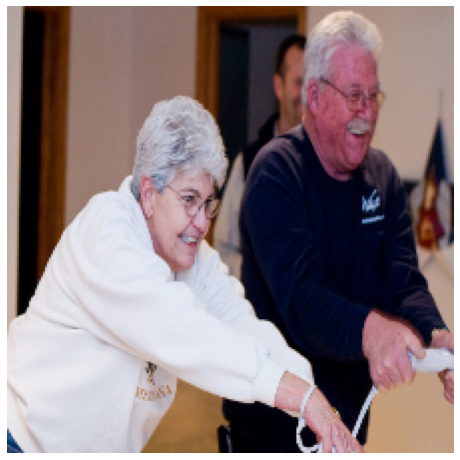

Categorias - TARGET
person ,  remote ,  cell phone ,  carpet ,  clothes ,  wall-concrete ,  wall-wood ,  other ,  
 Categorias - Classificação do modelo
person ,  clothes ,  wall-concrete ,  other ,  

In [ ]:
## Teste com exemplo de teste

inv_trans = transforms.Compose([transforms.Normalize(mean = [ 0., 0., 0. ], std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                                transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ], std = [ 1., 1., 1. ]),
                               ])

index = random.randrange(test_ex_num)
img, cats = test_dataset[index]

## Image categories (random image from the test set)
cats = torch.nonzero(cats).squeeze(1).numpy()
plt.axis('off')
plt.imshow(inv_trans(img).permute(1, 2, 0))
plt.show()

cats_inst_ids = cats[cats <= 91]
cats_inst = coco_inst_val.loadCats(cats_inst_ids)
cats_stuff_ids = cats[cats > 91]
cats_stuff = coco_stuff_val.loadCats(cats_stuff_ids)

print('Categorias - TARGET')
for i in range(len(cats_inst)):
    print(cats_inst[i]['name'], ', ', end=' ')

for i in range(len(cats_stuff)):
    print(cats_stuff[i]['name'], ', ', end=' ')

## Image predicted categories
model_1.eval()
img = img.to(device)
img = img.unsqueeze(0)
cats_predicted = model_1(img)
threshold = 0.35
cats_predicted[cats_predicted >= threshold] = 1
cats_predicted[cats_predicted < threshold] = 0
cats_predicted = cats_predicted.squeeze()
cats_predicted = torch.nonzero(cats_predicted).squeeze(1).cpu().numpy()

cats_predicted_inst_ids = cats_predicted[cats_predicted <= 91]
cats_predicted_inst = coco_inst_val.loadCats(cats_predicted_inst_ids)
cats_predicted_stuff_ids = cats_predicted[cats_predicted > 91]
cats_predicted_stuff = coco_stuff_val.loadCats(cats_predicted_stuff_ids)

print('\n Categorias - Classificação do modelo')
for i in range(len(cats_predicted_inst)):
    print(cats_predicted_inst[i]['name'], ', ', end=' ')

for i in range(len(cats_predicted_stuff)):
    print(cats_predicted_stuff[i]['name'], ', ', end=' ')
